In [1]:
import numpy as np
from scipy.interpolate import BSpline

In [49]:
def B_dp(
    x: np.ndarray, 
    t: np.ndarray, 
    c: np.ndarray, 
    k: int,
    extrapolate: bool = False
) -> np.ndarray:

    Nt, Dt = t.shape
    k1 = k + 1

    x_a = np.tile(x[:, np.newaxis], reps = (1, Dt))

    t_0, t_1 = t, np.roll(t, shift = -1, axis = 1)
    t_k, t_k1 = t_0, t_1

    t_extrapo = np.concatenate([
            np.ones(shape = (Nt, k1)) * float('-inf') if extrapolate else t_0[:, :k1],
            t_0[:, k1: -k1],
            np.ones(shape = (Nt, k1)) * float('inf') if extrapolate else t_0[:, -k1:],
        ], axis = 1
    )

    t_extrapo = t_0.copy()
    if extrapolate:
        t_extrapo[:, :k1] = float('-inf')
        t_extrapo[:, -k1:] = float('inf')

    dp_0 = np.logical_and(
        np.less_equal(t_extrapo, x_a),
        np.less(x_a, np.roll(t_extrapo, shift = -1, axis = 1)),
    ).astype(np.float64)

    for _ in range(k):
        # c1 part
        t_k = np.roll(t_k, shift = -1, axis = 1)
        c_1 = np.subtract(x_a, t_0) / np.subtract(t_k, t_0) * dp_0
        
        # c2 part
        t_k1  = np.roll(t_k1, shift = -1, axis = 1)
        c_2 = np.subtract(t_k1, x_a) / np.subtract(t_k1, t_1) * np.roll(dp_0, shift = -1, axis = 1)

        c_1 = np.where(t_k  == t_0, 0., c_1)
        c_2 = np.where(t_k1 == t_1, 0., c_2)

        dp_0 = c_1 + c_2

    return np.sum(c * dp_0[:, :Dt - k1], axis = 1)


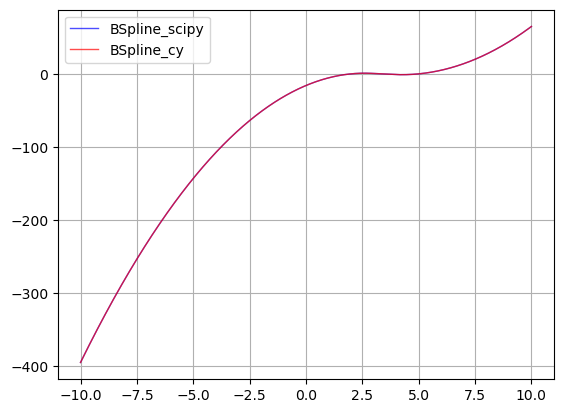

In [52]:
import matplotlib.pyplot as plt

k = 2
t = np.array([0, 1, 2, 3, 4, 5, 6, 7], dtype = np.float64)
c = np.array([-1, 2, 0, -1, 2], dtype = np.float64)

fig, ax = plt.subplots()
x = np.linspace(-10, 10, 1000)
spl = BSpline(t, c, k, extrapolate = True)
ax.plot(x, spl(x), 'b-', lw = 1, alpha = 0.7, label = 'BSpline_scipy')

tt = np.tile(t, reps = (1000, 1))
cc = np.tile(c, reps = (1000, 1))

ax.plot(x, B_dp(x, tt, cc, k, True), 'r-', lw = 1, alpha = 0.7, label = 'BSpline_cy')
ax.grid(True)
ax.legend(loc = 'best')
plt.show()